# WIDS Datathon 2022

**Paticipantes**: Adriana, Camila, Graciele, Luiz

**Grupo Kaggle**: Ararajuba

**Ponto de atenção**: O Desafio deste ano está voltado a previsão envolvendo aproximadamente **100 mil observações** de registros de uso de energia de edifícios coletados ao longo de 7 anos e vários estados nos Estados Unidos. O conjunto de dados consiste em características do edifício (por exemplo, área do piso, tipo de instalação, etc.), dados meteorológicos para a localização do edifício (por exemplo, temperatura média anual, precipitação total anual, etc.), bem como o uso de energia para o edifício e o ano determinado, medido como Intensidade de Uso de Energia do Local (Site EUI). Cada linha nos dados corresponde a um único edifício observado em um determinado ano. Sua tarefa é prever o EUI do Site para cada linha, dadas as características do edifício e os dados climáticos para a localização do edifício.

**Uso de dados externos**: A tarefa de datathon pode ser realizada com sucesso sem o uso de dados externos. Na verdade, o grau em que anonimizamos os dados dificultaria a junção de dados adicionais aos dados da concorrência. No entanto, os participantes que desejam fazê-lo podem usar dados externos adicionais com a finalidade de construir modelos preditivos.

**Métrica a ser encaminhada no resultado: AUC**

Tipos de algoritimos comuns: **XGBoost, CatBoost, Random Forest.**

**DICA**: Separe 5% dos dados para testes antes da submição

**Covariáveis**
  * id: id do edifício
  * Year_Factor: ano anônimo em que foram observados os fatores climáticos e de uso de energia
  * State_Factor: estado anônimo em que o edifício está localizado
  * building_class: classificação do edifício
  * tipo_de_instalação: tipo de uso do edifício
  * floor_area: área do piso (em pés quadrados) do edifício
  * year_built: ano em que o edifício foi construído
  * energy_star_rating: a classificação energética do edifício
  * ELEVAÇÃO: elevação do local do edifício
  * january_min_temp: temperatura mínima em janeiro (em Fahrenheit) no local do edifício
  * january_avg_temp: temperatura média em janeiro (em Fahrenheit) no local do edifício
  * january_max_temp: temperatura máxima em janeiro (em Fahrenheit) no local do edifício
  * cooler_degree_days: o grau de resfriamento por dia para um determinado dia é o número de graus em que a temperatura média diária excede 65 graus Fahrenheit. Cada mês é somado para produzir um total anual no local do edifício.
  *heating_degree_days: o dia do grau de aquecimento para um determinado dia é o número de graus em que a temperatura média diária cai abaixo de 65 graus Fahrenheit. Cada mês é somado para produzir um total anual no local do edifício.
  * precipitação_inches: precipitação anual em polegadas no local do edifício
  * snowfall_inches: queda de neve anual em polegadas no local do edifício
  * snowdepth_inches: profundidade anual da neve em polegadas no local do edifício
  * avg_temp: temperatura média ao longo de um ano no local do edifício
  * days_below_30F: número total de dias abaixo de 30 graus Fahrenheit no local do edifício
  * days_below_20F: número total de dias abaixo de 20 graus Fahrenheit no local do edifício
  * days_below_10F: número total de dias abaixo de 10 graus Fahrenheit no local do edifício
  * days_below_0F: número total de dias abaixo de 0 graus Fahrenheit no local do edifício
  * days_above_80F: número total de dias acima de 80 graus Fahrenheit no local do edifício
  * days_above_90F: número total de dias acima de 90 graus Fahrenheit no local do edifício
  * days_above_100F: número total de dias acima de 100 graus Fahrenheit no local do edifício
  * days_above_110F: número total de dias acima de 110 graus Fahrenheit no local do edifício
  * direction_max_wind_speed: direção do vento para velocidade máxima do vento no local do edifício. Dado em direções de ponto de bússola de 360 ​​graus (por exemplo, 360 = norte, 180 = sul, etc.).
  * direction_peak_wind_speed: direção do vento para a velocidade máxima da rajada de vento no local do edifício. Dado em direções de ponto de bússola de 360 ​​graus (por exemplo, 360 = norte, 180 = sul, etc.).
  * max_wind_speed: velocidade máxima do vento no local do edifício
  * days_with_fog: número de dias com neblina no local do prédio

**Target**
  * site_eui: Intensidade de uso de energia do local é a quantidade de calor e eletricidade consumida por um edifício conforme refletido nas contas de serviços públicos

# Setup

In [3]:
# Pandas nos permite trabajar con DataFrames
import pandas as pd
# Para la visualización de datos
import plotly.express as px
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve

# roc curve and auc score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#from sklearn import metrics as multioutput

from sklearn import metrics

%matplotlib inline
%load_ext google.colab.data_table

In [4]:
!pip install mglearn
!pip install kaggle
!mkdir ~/.kaggle
!touch '/root/.kaggle/kaggle.json'
######################################################################################
# Copia aquí tu USER NAME y API KEY de kaggle

api_token = {"username":"xx","key":"xx"}
######################################################################################


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
import mglearn

In [6]:
!kaggle competitions download -c widsdatathon2022

sample_solution.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
## Funções
alvo = 'site_eui'

def ler_arquivos(arquivo):
  df = pd.read_csv(arquivo)  
  print("Dimenções ",arquivo, "(filas, columnas)  : ", df.shape)
  return df

def remover_valores(df,column):
  df = df[(df[column].notnull())]
  print(df.shape)
  return df

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def missing_values(df):
  percent_missing = df.isnull().sum() * 100 / len(df)

  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing': percent_missing}).round(2)

  missing_value_df.sort_values('percent_missing', inplace=True)
  return missing_value_df

def model_performance(model,X_test, y_test, y_val_pred):
    '''Apresenta as métricas principais do modelo'''
    
    print("ACURÁCIA:                ",round(metrics.accuracy_score(y_test,y_val_pred),4))  
    print("SENSIBILIDADE:           ",round(metrics.recall_score(y_test,y_val_pred),4))
    print ("PRECISÃO:                ",round(metrics.precision_score(y_test, y_val_pred),4))
    print ("F1-SCORE:                ",round(metrics.f1_score(y_test, y_val_pred),4))
    print ("ERRO QUADRADO AJUSTADO:  ",round(metrics.adjusted_rand_score(y_test, y_val_pred),4))    
    print ("ROC SCORE:               ",round(metrics.roc_auc_score(y_test, y_val_pred),4))  
    print ("MATRIZ DE CONFUSÃO:      \n",metrics.confusion_matrix(y_test, y_val_pred))

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))

def fillnan_mean_facility_gp(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['facility_type_gp'],as_index=False).median().round(2)

    for index, row in gc.iterrows():
      df.loc[df.facility_type_gp== row['facility_type_gp'],column] = df.loc[df.facility_type_gp== row['facility_type_gp'],column].fillna(gc[gc['facility_type_gp'] == row['facility_type_gp']][column].median())
      
  return df

def normalizar_dataset(df,df_train):
  #v1
  df = fillnan_mean_facility_gp(df,df_train,"year_built")
  df = fillnan_mean_facility_gp(df,df_train,"energy_star_rating")
  df = fillnan_mean_facility_gp(df,df_train,"direction_max_wind_speed")
  df = fillnan_mean_facility_gp(df,df_train,"max_wind_speed")
  df = fillnan_mean_facility_gp(df,df_train,"direction_peak_wind_speed")
  df = fillnan_mean_facility_gp(df,df_train,"days_with_fog")

  #<to-do>

  return df

In [8]:
!unzip -o test.csv.zip
!unzip -o train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!ls

cache	     sample_solution.csv  test.csv	train.csv
sample_data  submission_1.0.csv   test.csv.zip	train.csv.zip


In [10]:
df_training          = ler_arquivos('train.csv')
df_test              = ler_arquivos('test.csv')
df_samplesubmission  = ler_arquivos('sample_solution.csv')

Dimenções  train.csv (filas, columnas)  :  (75757, 64)
Dimenções  test.csv (filas, columnas)  :  (9705, 63)
Dimenções  sample_solution.csv (filas, columnas)  :  (9705, 2)


In [11]:
df_samplesubmission.head(1)

,id,site_eui
0,75757,0.0


In [12]:
df_training.head(3).transpose()

,0,1,2
Year_Factor,1,1,1
State_Factor,State_1,State_1,State_1
building_class,Commercial,Commercial,Commercial
facility_type,Grocery_store_or_food_market,Warehouse_Distribution_or_Shipping_center,Retail_Enclosed_mall
floor_area,61242.0,274000.0,280025.0
...,...,...,...
direction_peak_wind_speed,1.0,NaN,NaN
max_wind_speed,1.0,1.0,1.0
days_with_fog,NaN,12.0,12.0
site_eui,248.682615,26.50015,24.693619


In [13]:
df_training.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year_Factor,75757.0,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000e+00
floor_area,75757.0,165983.865858,246875.790940,943.000000,62379.000000,91367.000000,166000.000000,6.385382e+06
year_built,73920.0,1952.306764,37.053619,0.000000,1927.000000,1951.000000,1977.000000,2.015000e+03
energy_star_rating,49048.0,61.048605,28.663683,0.000000,40.000000,67.000000,85.000000,1.000000e+02
ELEVATION,75757.0,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1.924500e+03
...,...,...,...,...,...,...,...,...
direction_peak_wind_speed,33946.0,62.779974,130.308106,1.000000,1.000000,1.000000,1.000000,3.600000e+02
max_wind_speed,34675.0,4.190601,6.458789,1.000000,1.000000,1.000000,1.000000,2.330000e+01
days_with_fog,29961.0,109.142051,50.699751,12.000000,88.000000,104.000000,131.000000,3.110000e+02
site_eui,75757.0,82.584693,58.255403,1.001169,54.528601,75.293716,97.277534,9.978661e+02


# Exploratório

In [14]:
missing_values(df_training)

,column_name,percent_missing
Year_Factor,Year_Factor,0.00
september_min_temp,september_min_temp,0.00
september_avg_temp,september_avg_temp,0.00
september_max_temp,september_max_temp,0.00
october_min_temp,october_min_temp,0.00
...,...,...
energy_star_rating,energy_star_rating,35.26
direction_max_wind_speed,direction_max_wind_speed,54.23
max_wind_speed,max_wind_speed,54.23
direction_peak_wind_speed,direction_peak_wind_speed,55.19


In [15]:
missing_values(df_test)

,column_name,percent_missing
Year_Factor,Year_Factor,0.00
september_min_temp,september_min_temp,0.00
september_avg_temp,september_avg_temp,0.00
september_max_temp,september_max_temp,0.00
october_min_temp,october_min_temp,0.00
...,...,...
energy_star_rating,energy_star_rating,23.23
direction_max_wind_speed,direction_max_wind_speed,88.36
direction_peak_wind_speed,direction_peak_wind_speed,88.36
max_wind_speed,max_wind_speed,88.36


### ***Tratar Dummies***

In [16]:
df_training          = ler_arquivos('train.csv')
df_test              = ler_arquivos('test.csv')
df_samplesubmission  = ler_arquivos('sample_solution.csv')

Dimenções  train.csv (filas, columnas)  :  (75757, 64)
Dimenções  test.csv (filas, columnas)  :  (9705, 63)
Dimenções  sample_solution.csv (filas, columnas)  :  (9705, 2)


In [17]:
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.options.display.max_columns = 100

cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['State_Factor', 'building_class', 'facility_type']


In [18]:
df_training.State_Factor.unique()

array(['State_1', 'State_2', 'State_4', 'State_6', 'State_8', 'State_10',
       'State_11'], dtype=object)

In [19]:
df_training.building_class.unique()

array(['Commercial', 'Residential'], dtype=object)

In [20]:
df_training.facility_type.unique()

array(['Grocery_store_or_food_market',
       'Warehouse_Distribution_or_Shipping_center',
       'Retail_Enclosed_mall', 'Education_Other_classroom',
       'Warehouse_Nonrefrigerated', 'Warehouse_Selfstorage',
       'Office_Uncategorized', 'Data_Center', 'Commercial_Other',
       'Mixed_Use_Predominantly_Commercial',
       'Office_Medical_non_diagnostic', 'Education_College_or_university',
       'Industrial', 'Laboratory',
       'Public_Assembly_Entertainment_culture',
       'Retail_Vehicle_dealership_showroom', 'Retail_Uncategorized',
       'Lodging_Hotel', 'Retail_Strip_shopping_mall',
       'Education_Uncategorized', 'Health_Care_Inpatient',
       'Public_Assembly_Drama_theater', 'Public_Assembly_Social_meeting',
       'Religious_worship', 'Mixed_Use_Commercial_and_Residential',
       'Office_Bank_or_other_financial', 'Parking_Garage',
       'Commercial_Unknown', 'Service_Vehicle_service_repair_shop',
       'Service_Drycleaning_or_Laundry', 'Public_Assembly_Recreation

In [21]:
df_training['State_Factor_'] = df_training['State_Factor']
df_test['State_Factor_'] = df_test['State_Factor']

df_training_temp = df_training

df_training = pd.get_dummies(df_training_temp, columns=['State_Factor'])
df_test = pd.get_dummies(df_test, columns=['State_Factor'])

In [22]:
#df_training['building_class_'] = df_training['building_class']
#df_test['building_class_'] = df_test['building_class']
#
#df_training_temp = df_training
#
#df_training = pd.get_dummies(df_training_temp, columns=['building_class'])
#df_test = pd.get_dummies(df_test, columns=['building_class'])

In [23]:
df_training['building_class_'] = df_training['building_class']
df_test['building_class_'] = df_test['building_class']

replace_map = {'building_class': {'Commercial': 1, 'Residential': 0}}

#labels = df_training['building_class'].astype('category').cat.categories.tolist()
#replace_map_comp = {'building_class' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map, inplace=True)
df_test.replace(replace_map, inplace=True)

In [24]:
df_training['facility_type_']  = df_training['facility_type']
df_test['facility_type_'] = df_test['facility_type']

replace_map = {'facility_type': { 'Grocery_store_or_food_market': 1,
                                  'Warehouse_Distribution_or_Shipping_center' : 2,
                                  'Retail_Enclosed_mall' : 3,
                                  'Education_Other_classroom' : 4,
                                  'Warehouse_Nonrefrigerated': 5,
                                  'Warehouse_Selfstorage': 6,
                                  'Office_Uncategorized': 7,
                                  'Data_Center': 8, 
                                  'Commercial_Other' :9,
                                  'Mixed_Use_Predominantly_Residential' : 10,
                                  'Office_Medical_non_diagnostic' : 11, 
                                  'Education_College_or_university' : 12,
                                  'Industrial' : 13, 
                                  'Laboratory' : 14,
                                  'Public_Assembly_Entertainment_culture' : 15,
                                  'Retail_Vehicle_dealership_showroom' : 16, 
                                  'Retail_Uncategorized' : 17,
                                  'Lodging_Hotel': 18, 
                                  'Retail_Strip_shopping_mall': 19,
                                  'Education_Uncategorized': 20, 
                                  'Health_Care_Inpatient' : 21,
                                  'Public_Assembly_Drama_theater' : 22, 
                                  'Public_Assembly_Social_meeting' : 23,
                                  'Religious_worship' : 24, 
                                  'Mixed_Use_Commercial_and_Residential' : 25,
                                  'Office_Bank_or_other_financial' : 26, 
                                  'Parking_Garage' : 27,
                                  'Commercial_Unknown' : 28, 
                                  'Service_Vehicle_service_repair_shop' : 29,
                                  'Service_Drycleaning_or_Laundry': 30, 
                                  'Public_Assembly_Recreation': 31,
                                  'Service_Uncategorized': 32, 
                                  'Warehouse_Refrigerated': 33,
                                  'Food_Service_Uncategorized' : 34, 
                                  'Health_Care_Uncategorized' : 35,
                                  'Food_Service_Other' : 36, 
                                  'Public_Assembly_Movie_Theater' : 37,
                                  'Food_Service_Restaurant_or_cafeteria' : 38, 
                                  'Food_Sales' : 39,
                                  'Public_Assembly_Uncategorized' : 40, 
                                  'Nursing_Home' : 41,
                                  'Health_Care_Outpatient_Clinic' : 42, 
                                  'Education_Preschool_or_daycare' : 43,
                                  '5plus_Unit_Building' : 44, 
                                  'Multifamily_Uncategorized' : 45,
                                  'Lodging_Dormitory_or_fraternity_sorority': 46,
                                  'Public_Assembly_Library': 47, 
                                  'Public_Safety_Uncategorized': 48,
                                  'Public_Safety_Fire_or_police_station' : 49, 
                                  'Office_Mixed_use' : 50,
                                  'Public_Assembly_Other' : 51, 
                                  'Public_Safety_Penitentiary' : 52,
                                  'Health_Care_Outpatient_Uncategorized' : 53, 
                                  'Lodging_Other' : 54,
                                  'Mixed_Use_Preadominantly_Residential' : 55, 
                                  'Public_Safety_Courthouse' : 56,
                                  'Public_Assembly_Stadium' : 57, 
                                  'Lodging_Uncategorized' : 58,
                                  '2to4_Unit_Building' : 59, 
                                  'Warehouse_Uncategorized' : 60
                                 }
               }
#labels = df_training['facility_type'].astype('category').cat.categories.tolist()
#replace_map_comp = {'facility_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map, inplace=True)
df_test.replace(replace_map, inplace=True)

In [25]:
df_training['facility_type_gp']  = df_training['facility_type_']
df_test['facility_type_gp'] = df_test['facility_type_']

replace_map = {'facility_type_gp': { 
                                      'Mixed_Use_Preadominantly_Residential' : 1, 
                                      'Mixed_Use_Predominantly_Residential' : 1,
                                      'Office_Medical_non_diagnostic' : 1, 
                                      'Office_Uncategorized': 1,
                                      'Mixed_Use_Commercial_and_Residential' : 1,
                                      'Office_Bank_or_other_financial' : 1, 
                                      'Office_Mixed_use' : 1,         

                                      'Education_Uncategorized': 2, 
                                      'Education_College_or_university' : 2,
                                      'Education_Other_classroom' : 2,
                                      'Education_Preschool_or_daycare' : 2,
                                      'Religious_worship' : 2,

                                      'Warehouse_Nonrefrigerated': 3,
                                      'Warehouse_Selfstorage': 3,
                                      'Grocery_store_or_food_market': 3,
                                      'Warehouse_Distribution_or_Shipping_center' : 3,
                                      'Retail_Uncategorized' : 3,                                  
                                      'Warehouse_Refrigerated': 3,
                                      'Food_Service_Restaurant_or_cafeteria' : 3, 
                                      'Food_Sales' : 3,
                                      'Food_Service_Uncategorized' : 3, 
                                      'Warehouse_Uncategorized' : 3,     
                                      'Food_Service_Other' : 3, 

                                      'Public_Assembly_Entertainment_culture' : 4,
                                      'Public_Assembly_Drama_theater' : 4, 
                                      'Public_Assembly_Social_meeting' : 4,
                                      'Public_Assembly_Recreation': 4,
                                      'Public_Assembly_Movie_Theater' : 4,
                                      'Public_Assembly_Uncategorized' : 4,
                                      'Public_Assembly_Library': 4,      
                                      'Public_Safety_Uncategorized': 4,
                                      'Public_Safety_Fire_or_police_station' : 4, 
                                      'Public_Safety_Courthouse' : 4,
                                      'Public_Assembly_Stadium' : 4, 
                                      'Public_Assembly_Other' : 4, 
                                      'Public_Safety_Penitentiary' : 4,

                                      'Lodging_Hotel': 5, 
                                      'Retail_Strip_shopping_mall': 5,
                                      'Lodging_Uncategorized' : 5,
                                      'Lodging_Other' : 5,
                                      'Lodging_Dormitory_or_fraternity_sorority': 5,

                                      'Health_Care_Inpatient' : 6,
                                      'Health_Care_Uncategorized' : 6,
                                      'Health_Care_Outpatient_Clinic' : 6, 
                                      'Health_Care_Outpatient_Uncategorized' : 6, 
                                      'Nursing_Home' : 6,
                                      'Multifamily_Uncategorized' : 6,

                                      'Data_Center': 7, 
                                      'Industrial' : 7, 
                                      'Laboratory' : 7,
                                      'Parking_Garage' : 7,
                                      'Commercial_Unknown' : 7, 
                                      'Commercial_Other' :7,
                                      'Service_Drycleaning_or_Laundry': 7, 
                                      'Retail_Enclosed_mall' : 7,
                                      'Mixed_Use_Predominantly_Commercial' : 7,
                                      'Service_Uncategorized': 7, 
                                      'Retail_Vehicle_dealership_showroom' : 7, 
                                      'Service_Vehicle_service_repair_shop' : 7,
                                      '5plus_Unit_Building' : 7, 
                                      '2to4_Unit_Building' : 7, 

                                 }
               }

#labels = df_training['facility_type_gp'].astype('category').cat.categories.tolist()
#replace_map_comp = {'facility_type_gp' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map, inplace=True)
df_test.replace(replace_map, inplace=True)

In [26]:
df_training['facility_type_gp_']  = df_training['facility_type_gp']
df_test['facility_type_gp_'] = df_test['facility_type_gp']

replace_map = {'facility_type_gp_': { 
                                      1 : 'Offices', 
                                      2 : 'Education or Religious', 
                                      3 : 'Food, Warehouse and Grocery', 
                                      4 : 'Publics', 
                                      5 : 'Lodging and Hotels', 
                                      6 : 'Health Care', 
                                      7 : 'Industrial, Commercial and Others'
                                 }
               }

df_training.replace(replace_map, inplace=True)
df_test.replace(replace_map, inplace=True)

In [27]:
df_training.facility_type_gp_.unique()

array(['Food, Warehouse and Grocery', 'Industrial, Commercial and Others',
       'Education or Religious', 'Offices', 'Publics',
       'Lodging and Hotels', 'Health Care'], dtype=object)

In [28]:
#Deve retornar apenas as categorias com "*_"
cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['facility_type', 'State_Factor_', 'building_class_', 'facility_type_', 'facility_type_gp_']


In [29]:
print('Training', df_training.shape)
print('Solution', df_test.shape) #-1 variável targuet

Training (75757, 75)
Solution (9705, 73)


In [30]:
df_test = df_test.reindex(columns = df_training.columns, fill_value=0)

In [31]:
print('Training', df_training.shape)
print('Solution', df_test.shape)

Training (75757, 75)
Solution (9705, 75)


## Data Discovery

Observando a variável de tipo de empreendimento (**building_class**)

Podemos ver uma diferença significativa em:
  
  * Tipo de instalação (facility_type)
  * Tamanho da área (floor_area)
  * Classificação energética do empreendimento (energy_star_rating)
  * Temperatura mínima e média em Janeiro (january_min_temp e january_avg_temp)
  * Temperatura mínima, máxima e média em Fevereiro 
  * Temperatura mínima, máxima e média em Abril 
  * Temperatura média e máxima em Junho 
  * Temperatura mínima, média e máxima em Julho 
  * Temperatura mínima, média e máxima em Agosto
  * Temperatura média em Dezembro
  * Grau de resfriamento por dia (cooler_degree_days tmp > 65 Fr)
  * Grau de aquicimento por dia (heating_degree_days tmp < 65 Fr)  


In [35]:
df_training.columns

#Deve retornar apenas as categorias com "*_"
non_cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] not in ['object'] ]

print('Features non categoricas ',non_cat_var)

Features non categoricas  ['Year_Factor', 'building_class', 'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_

In [36]:
# Construindo Boxplots por target com alta mudança na mediana
#df_training_temp = pd.melt(df_training[non_cat_var], 
#                                        id_vars='facility_type_gp')

# sharey=False (Escala livre)
#g = sns.FacetGrid(df_training_temp, col="variable", sharey=False, col_wrap=5,  height=3.5)
#g.map_dataframe(sns.boxplot, x="facility_type_gp", y="value", showfliers=False)

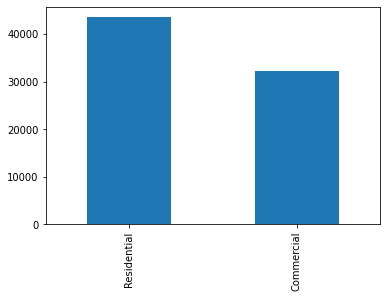

In [37]:
tab = df_training['building_class_'].value_counts()

#Gráfico de Barras
tab.plot(kind='bar')

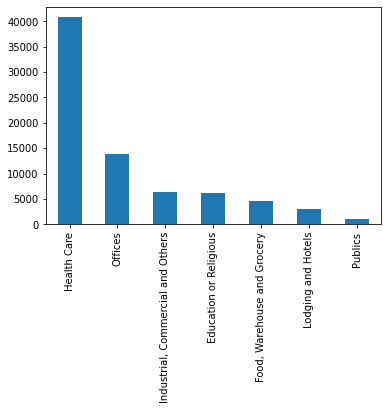

In [38]:
tab = df_training['facility_type_gp_'].value_counts()

#Gráfico de Barras
tab.plot(kind='bar')

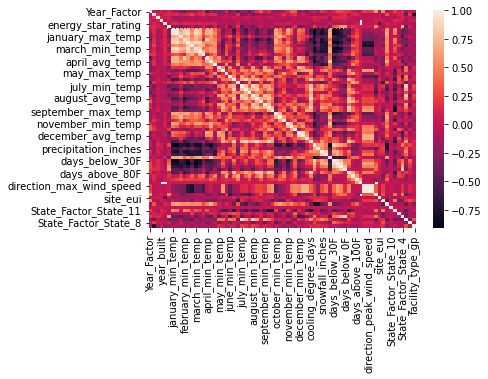

In [39]:
# Mapa de calor da matriz de correlação, usando seaboarn (sns)
df_training_cor = df_training

sns.heatmap(df_training_cor.corr())

In [40]:
df = df_training_cor

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Output hidden; open in https://colab.research.google.com to view.

In [41]:
df_training.facility_type_gp_.value_counts(normalize=True)

Health Care                          0.538287
Offices                              0.182571
Industrial, Commercial and Others    0.084995
Education or Religious               0.080943
Food, Warehouse and Grocery          0.061064
Lodging and Hotels                   0.039072
Publics                              0.013068
Name: facility_type_gp_, dtype: float64

In [42]:
df_test.facility_type_gp_.value_counts(normalize=True)

Health Care                          0.251108
Industrial, Commercial and Others    0.232045
Offices                              0.231221
Education or Religious               0.126945
Food, Warehouse and Grocery          0.089129
Lodging and Hotels                   0.053168
Publics                              0.016383
Name: facility_type_gp_, dtype: float64

In [43]:
 #Primeiro dataset para substituir os missing e o segundo o que irá obter as médias ou medianas (colocamos sempre o dataset de treino para incluir a media)
df_training_test =  normalizar_dataset(df_training,df_training)
df_test_test = normalizar_dataset(df_test,df_training)

In [44]:
alvo

'site_eui'

In [45]:
df = df_training_test

target = df_training_test[alvo]

df.drop(alvo, axis=1, inplace=True)
df.insert(len(df.columns), alvo, target)

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')

df_correlacao_negativa = corrmat.sort_values(alvo, ascending=True)
df_corr_top_corr_neg = df_correlacao_negativa.head(60)

df_correlacao_positiva = corrmat.sort_values(alvo, ascending=False)
df_corr_top_corr_posit = df_correlacao_positiva.head(60)

print("Top 60 features Corr+: ", df_corr_top_corr_posit.index)
print("Top 60 features Corr-: ", df_corr_top_corr_neg.index)

Top 60 features Corr+:  Index(['site_eui', 'snowfall_inches', 'heating_degree_days', 'days_below_30F',
       'july_avg_temp', 'cooling_degree_days', 'june_avg_temp',
       'State_Factor_State_6', 'days_below_20F', 'august_avg_temp',
       'precipitation_inches', 'snowdepth_inches', 'september_avg_temp',
       'july_min_temp', 'september_max_temp', 'august_min_temp',
       'days_above_80F', 'days_below_10F', 'floor_area', 'may_avg_temp',
       'days_below_0F', 'september_min_temp', 'december_max_temp',
       'State_Factor_State_4', 'facility_type_gp', 'july_max_temp',
       'building_class', 'june_min_temp', 'may_max_temp',
       'direction_peak_wind_speed', 'max_wind_speed',
       'direction_max_wind_speed', 'august_max_temp', 'october_max_temp',
       'State_Factor_State_8', 'year_built', 'november_max_temp', 'ELEVATION',
       'may_min_temp', 'State_Factor_State_10', 'days_above_90F',
       'days_above_110F', 'State_Factor_State_2', 'id', 'june_max_temp',
       'days_wi

In [46]:
#Deve retornar apenas as categorias com "*_"
cat_var = [key for key in dict(df_training_test.dtypes)
             if dict(df_training_test.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['facility_type', 'State_Factor_', 'building_class_', 'facility_type_', 'facility_type_gp_']


In [47]:
df_training_test  = df_training_test.drop(cat_var,axis = 1)
df_test_test = df_test_test.drop(cat_var,axis = 1)

In [48]:
missing_values(df_training_test)

,column_name,percent_missing
Year_Factor,Year_Factor,0.0
november_avg_temp,november_avg_temp,0.0
november_max_temp,november_max_temp,0.0
december_min_temp,december_min_temp,0.0
december_avg_temp,december_avg_temp,0.0
...,...,...
june_min_temp,june_min_temp,0.0
may_max_temp,may_max_temp,0.0
may_avg_temp,may_avg_temp,0.0
july_avg_temp,july_avg_temp,0.0


In [49]:
missing_values(df_test_test)

,column_name,percent_missing
Year_Factor,Year_Factor,0.0
november_avg_temp,november_avg_temp,0.0
november_max_temp,november_max_temp,0.0
december_min_temp,december_min_temp,0.0
december_avg_temp,december_avg_temp,0.0
...,...,...
june_min_temp,june_min_temp,0.0
may_max_temp,may_max_temp,0.0
may_avg_temp,may_avg_temp,0.0
july_avg_temp,july_avg_temp,0.0


In [50]:
print(df_training_test.shape)
print(df_test_test.shape)

(75757, 70)
(9705, 70)


# **Aplicação do Modelo**


#### **Configuração**

**Divisão do modelo**

In [51]:
alvo

'site_eui'

In [52]:
SEED = 14
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))

#semente   
random_state = 14
estimator = 160

# creating independent features X and dependant feature Y
y = df_training_test[alvo]
X = df_training_test.drop(alvo,axis = 1)

# Split into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

#Balanceamento não efetivo
#X_train, y_train = sm.fit_sample(X_train,y_train)

### 1º Modelo - **Regressão Linear**

In [ ]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
all_columns = "+".join(df_training_test.columns)
all_columns

'Year_Factor+building_class+floor_area+year_built+energy_star_rating+ELEVATION+january_min_temp+january_avg_temp+january_max_temp+february_min_temp+february_avg_temp+february_max_temp+march_min_temp+march_avg_temp+march_max_temp+april_min_temp+april_avg_temp+april_max_temp+may_min_temp+may_avg_temp+may_max_temp+june_min_temp+june_avg_temp+june_max_temp+july_min_temp+july_avg_temp+july_max_temp+august_min_temp+august_avg_temp+august_max_temp+september_min_temp+september_avg_temp+september_max_temp+october_min_temp+october_avg_temp+october_max_temp+november_min_temp+november_avg_temp+november_max_temp+december_min_temp+december_avg_temp+december_max_temp+cooling_degree_days+heating_degree_days+precipitation_inches+snowfall_inches+snowdepth_inches+avg_temp+days_below_30F+days_below_20F+days_below_10F+days_below_0F+days_above_80F+days_above_90F+days_above_100F+days_above_110F+direction_max_wind_speed+direction_peak_wind_speed+max_wind_speed+days_with_fog+id+State_Factor_State_1+State_Facto

In [ ]:
# Ajuste do modelo de Regressão Linear
lm_esc = smf.ols(formula='site_eui ~ Year_Factor+building_class+floor_area+year_built+energy_star_rating+ELEVATION+january_min_temp+january_avg_temp+january_max_temp+february_min_temp+february_avg_temp+february_max_temp+march_min_temp+march_avg_temp+march_max_temp+april_min_temp+april_avg_temp+april_max_temp+may_min_temp+may_avg_temp+may_max_temp+june_min_temp+june_avg_temp+june_max_temp+july_min_temp+july_avg_temp+july_max_temp+august_min_temp+august_avg_temp+august_max_temp+september_min_temp+september_avg_temp+september_max_temp+october_min_temp+october_avg_temp+october_max_temp+november_min_temp+november_avg_temp+november_max_temp+december_min_temp+december_avg_temp+december_max_temp+cooling_degree_days+heating_degree_days+precipitation_inches+snowfall_inches+snowdepth_inches+avg_temp+days_below_30F+days_below_20F+days_below_10F+days_below_0F+days_above_80F+days_above_90F+days_above_100F+days_above_110F+direction_max_wind_speed+direction_peak_wind_speed+max_wind_speed+days_with_fog+id+State_Factor_State_1+State_Factor_State_10+State_Factor_State_11+State_Factor_State_2+State_Factor_State_4+State_Factor_State_6+State_Factor_State_8+facility_type_gp', 
                 data=df_training_test).fit()

# Saída do modelo
lm_esc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               site_eui   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     266.0
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:40:42   Log-Likelihood:            -4.0732e+05
No. Observations:               75757   AIC:                         8.148e+05
Df Residuals:                   75688   BIC:                         8.154e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   548.7884   1347.302      0.407      0.684   -2091.917    3189.494
Year_Factor                  -1.2692      2.148     -0.591      0.555      -5.478       2.940
building_class               32.4554      0.632     51.335      0.000      31.216      33.695
floor_area                 1.286e-05   8.11e-07     15.855      0.000    1.13e-05    1.45e-05
year_built                    0.0011      0.005      0.208      0.835      -0.009       0.012
energy_star_rating           -0.8785      0.008   -105.387      0.000      -0.895      -0.862
ELEVATION                    -0.0229      0.005     -4.306      0.000      -0.033      -0.012
january_min_temp              0.9195      0.661      1.391      0.164      -0.376       2.215
january_avg_temp              6.7894      3.245      2.092      0.036       0.429      13.150
january_max_temp             -1.2413      0.637     -1.948      0.051      -2.490       0.007
february_min_temp            -0.0057      0.550     -0.010      0.992      -1.083       1.071
february_avg_temp             1.4583      2.543      0.573      0.566      -3.526       6.442
february_max_temp             0.0270      0.848      0.032      0.975      -1.636       1.690
march_min_temp               -0.5257      0.692     -0.760      0.447      -1.881       0.830
march_avg_temp                1.3187      2.565      0.514      0.607      -3.709       6.347
march_max_temp                1.0792      0.622      1.736      0.083      -0.139       2.298
april_min_temp                0.6152      0.795      0.774      0.439      -0.943       2.174
april_avg_temp                4.3938      2.539      1.730      0.084      -0.583       9.371
april_max_temp               -0.2135      0.836     -0.255      0.798      -1.853       1.426
may_min_temp                 -0.3907      0.711     -0.549      0.583      -1.784       1.003
may_avg_temp                  2.1911      2.753      0.796      0.426      -3.204       7.586
may_max_temp                 -0.7365      0.789     -0.933      0.351      -2.283       0.810
june_min_temp                -0.4522      1.064     -0.425      0.671      -2.538       1.633
june_avg_temp                 5.5388      4.580      1.209      0.227      -3.438      14.515
june_max_temp                 1.3099      0.801      1.635      0.102      -0.261       2.881
july_min_temp                 0.5660      1.232      0.459      0.646      -1.849       2.981
july_avg_temp                -3.8966      2.418     -1.612      0.107      -8.635       0.842
july_max_temp                 1.3828      0.732      1.889      0.059      -0.052       2.818
august_min_temp               0.5970      0.864      0.691      0.490      -1.097       2.291
august_avg_temp               9.3020      2.665      3.491      0.000      

In [100]:
#Primeiro modelo
print(df_training_test.shape)
print(df_test_test.shape)

(75757, 70)
(9705, 70)


### 2º Modelo - **Voting Regression**

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

#Gradient Boosting Classifier
GBR = GradientBoostingRegressor(random_state=random_state)

# Random Forest Classifier
RFR = RandomForestRegressor(n_estimators=estimator) # TO-DO Ajustar com valor adequado

# Voting Classifier with soft voting 
vtc = VotingRegressor(estimators=[('rfc', RFR),('gbc',GBR)])
vtc = vtc.fit(X_train, y_train)

vtc_predict_y = vtc.predict(X_test)

#results = cross_val_score(vtc, X_train, y_train, cv = cv, 
#                          scoring = 'precision')
#intervalo_prec(results)

In [75]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(15152, 69)
(60605, 69)
(15152,)
(60605,)


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# aplicamos o modelo de regressão linear usando LinearRegression()
modelo = linear_model.LinearRegression()

# treinamos o modelo usando os dados de treinamento
modelo.fit(X_train, y_train)

# erro quadrático médio
r2 = np.mean((modelo.predict(X_test) - y_test) ** 2)

print('R²: ',r2)

R²:  2975.4119999723084


In [64]:
# variância
modelo.score(X_test, y_test)

0.1843508519472371

In [138]:
print(X_test.shape)
print(X_test.shape)

(15152, 69)


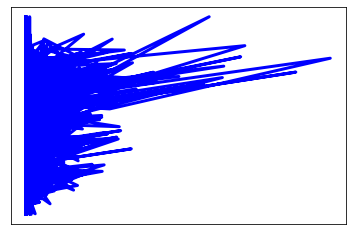

In [140]:
# plotamos os resultados definindo algumas características do gráfico
#plt.scatter(X_test,  df_test_test,  color='black')
plt.plot( df_test_test, modelo.predict( df_test_test), color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
  
plt.show()

In [82]:
modelo.coef_

array([-1.10203588e+00,  3.21352808e+01,  1.29886712e-05,  2.68324393e-03,
       -8.72481961e-01, -2.81281087e-02,  6.17106145e-01,  5.70881108e+00,
       -1.31199769e+00,  7.37432454e-02, -7.08982830e-01,  1.25067157e+00,
        5.45317843e-02,  1.51697323e+00,  6.61081588e-01,  4.19289806e-01,
        5.96288780e+00, -4.17873562e-01, -1.38148266e+00,  5.96192018e-01,
       -7.92546006e-01,  2.14426283e-01,  4.47651383e+00,  7.84488899e-01,
       -7.44553689e-01, -2.45655674e+00,  1.05134831e+00, -2.62585122e-01,
        9.29263529e+00, -4.11209762e-01, -8.27606701e-01,  2.23189348e-01,
       -4.19402636e-01,  6.45743362e-01,  5.42175934e+00, -8.21203166e-01,
       -3.12433727e-02,  1.72579972e+00, -1.79081201e-01,  1.77667959e-01,
        1.56316716e+00,  9.23375912e-01,  5.17208390e-02, -4.22426492e-02,
        6.71343910e-01, -6.32253531e-01,  3.78785035e-02, -4.53593001e+01,
       -3.54648364e-02,  1.14894006e+00, -1.12900184e+00, -2.50540432e-01,
       -1.58247563e-01,  

In [88]:
 results = modelo.predict(X_test)

In [90]:
results

array([46.3818477 , 57.51653373, 59.03307858, ..., 65.75746044,
       81.61329132, 80.40595637])

In [110]:
print('Training', df_training.shape)
print('Solution', df_test.shape)

Training (75757, 75)
Solution (9705, 74)


## **Comparação dos Modelos** 

======================= Voting C ========================

ACURÁCIA:                 0.8294
SENSIBILIDADE:            0.3967
PRECISÃO:                 0.6794
F1-SCORE:                 0.5009
ERRO QUADRADO AJUSTADO:   0.3091
ROC SCORE:                0.6726
MATRIZ DE CONFUSÃO:      
 [[19361  1052]
 [ 3390  2229]]
===================== Random Forest =====================

ACURÁCIA:                 0.8248
SENSIBILIDADE:            0.3542
PRECISÃO:                 0.6813
F1-SCORE:                 0.466
ERRO QUADRADO AJUSTADO:   0.2827
ROC SCORE:                0.6543
MATRIZ DE CONFUSÃO:      
 [[19482   931]
 [ 3629  1990]]
===================== Voting C_v4 =======================

ACURÁCIA:                 0.8274
SENSIBILIDADE:            0.3817
PRECISÃO:                 0.6902
F1-SCORE:                 0.4915
ERRO QUADRADO AJUSTADO:   0.3015
ROC SCORE:                0.6669
MATRIZ DE CONFUSÃO:      
 [[19366   975]
 [ 3519  2172]]


**********************      ROC      *****************

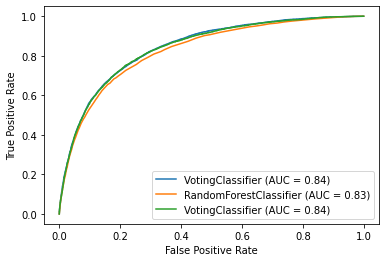

In [ ]:
print('======================= Voting C ========================\n')
model_performance(vtc, X_test, y_test, vtc_predict_y)
print('===================== Random Forest =====================\n')
model_performance(rf1, X_test, y_test, rf1_y_val_pred)
print('===================== Voting C_v4 =======================\n')
model_performance(vtc4, X_test_v4, y_test_v4, vtc4_predict_y)

print('\n\n**********************      ROC      **********************\n\n')
ax = plt.gca()

resp = metrics.plot_roc_curve(vtc, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(rf1, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(vtc4, X_test_v4, y_test_v4, ax=ax)
plt.show()

#BEST: 0.84
#KAGLE 0.83432

## **Selecionar Modelo para Submissão Final**

In [135]:
print(df_training_test.shape)
print(df_test.shape)
print(df_samplesubmission.shape)

(75757, 70)
(9705, 63)
(9705, 2)


In [92]:
df_samplesubmission.head()

,id,site_eui
0,75757,0.0
1,75758,0.0
2,75759,0.0
3,75760,0.0
4,75761,0.0


In [57]:
test = df_test_test
test1 = test.copy()

test.drop('site_eui',axis = 1, inplace=True, errors='ignore')
test1.drop('site_eui',axis = 1, inplace=True, errors='ignore')

In [ ]:
#test = df_unlabeled_test_v4
#test1 = test.copy()
#
#test.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')
#test1.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')

In [65]:
file = 'submission_1.0.csv' #Submissão v1 com ajuste agrupamento de facility e modelo de regressão simples

test = df_test_test
test1 = test.copy()

test1["site_eui"] = modelo.predict(test)
test1[["id","site_eui"]].to_csv(file,index=False)
test1[["id","site_eui"]].head()

,id,site_eui
0,75757,113.618727
1,75758,96.522566
2,75759,143.155690
3,75760,116.142989
4,75761,122.816274


In [66]:
!kaggle competitions submit -c widsdatathon2022 -f submission_1.0.csv -m "Submissão v1 com ajuste agrupamento de facility e modelo de regressão simples"

100% 233k/233k [00:04<00:00, 48.5kB/s]
Successfully submitted to WiDS Datathon 2022

In [68]:
file = 'submission_2.0.csv' #Submissão v2 com ajuste agrupamento de facility e Votting Regression

test = df_test_test
test1 = test.copy()

test1["site_eui"] = vtc.predict(test)
test1[["id","site_eui"]].to_csv(file,index=False)
test1[["id","site_eui"]].head()

,id,site_eui
0,75757,147.790728
1,75758,87.308984
2,75759,157.038616
3,75760,149.482427
4,75761,93.730506


In [69]:
!kaggle competitions submit -c widsdatathon2022 -f submission_2.0.csv -m "Submissão v2 com ajuste agrupamento de facility e Votting Regression"

100% 233k/233k [00:05<00:00, 42.0kB/s]
Successfully submitted to WiDS Datathon 2022